# Download the dataset (https://www.floydhub.com/emilwallner/datasets/colornet)

In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image as k_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab, gray2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


/Users/massimo/anaconda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img = k_img.load_img('dataset/images/Train/0A9kTN.jpg')
img_arr = np.array(k_img.img_to_array(img), dtype=float)*1.0/255

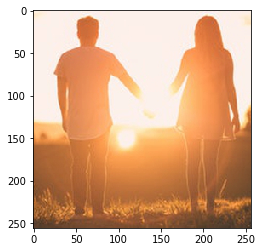

In [4]:
plt.imshow(lab2rgb(rgb2lab(img_arr))) #test

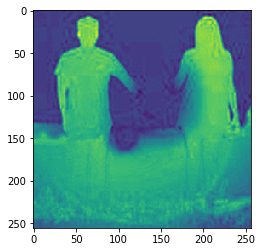

In [5]:
plt.imshow(rgb2lab(img_arr)[:,:,1])

In [6]:
import os
imgs = os.listdir("dataset/images/Train")[:500]#cut dataset... (too big?)
dataset = np.zeros((len(imgs), 256,256,3), dtype=float)
k=0
for i in imgs:
    dataset[k] = k_img.img_to_array(k_img.load_img('dataset/images/Train/'+i))
    k+=1
dataset/=255#float: 0-255 -> 0-1

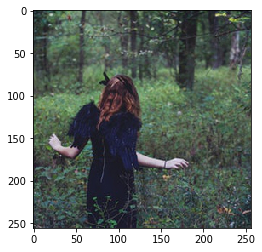

In [7]:
plt.imshow(lab2rgb(rgb2lab(dataset[1])))

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception = InceptionResNetV2(weights="dataset/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")
#inception.load_weights('')
inception.graph = tf.get_default_graph()

image_gen = ImageDataGenerator(shear_range=0.4,zoom_range=0.4,rotation_range=40,horizontal_flip=True)
image_gen.fit(dataset)

def generate_classification(batch_data):
    resized = np.zeros((len(batch_data),299,299,3))
    k=0
    for i in batch_data:
        resized[k] = resize(i, (299, 299, 3), mode='constant')#skimage resize, ResNet V2 models use input image size of 299
        k+=1
    resized = preprocess_input(resized)
    with inception.graph.as_default():
        embed = inception.predict(resized)
    return embed
def data_generator(batch_size = 20):
    for batch in image_gen.flow(dataset, batch_size=batch_size):
        classification = generate_classification(gray2rgb(rgb2gray(batch)))# 3-layers grey image, InceptionResNetV2 works with RGB but we can't use informations obtained from a full RGB picture
        lab = rgb2lab(batch)
        x = lab[:,:,:,0]#grey scale of the all batch (batch, 256,256)
        x = x.reshape(x.shape+(1,)) #(batch, 256, 256, 1) 1 layer, 256*256, batch pics
        y = lab[:,:,:,1:] / 128 #(batch, 256, 256, 2)
        yield ([x, classification], y)#[x,classification] input of network

/Users/massimo/anaconda/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Grey image:  (1, 256, 256, 1)
Classification:  (1, 1000)
target image:  (1, 256, 256, 2)
[[('n03729826', 'matchstick', 0.1259519), ('n03196217', 'digital_clock', 0.09826995), ('n01930112', 'nematode', 0.08023516)]]


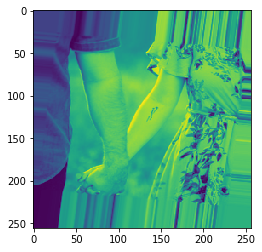

In [12]:
#TEST
from keras.applications.inception_resnet_v2 import decode_predictions
a=0
for i,j in data_generator(batch_size=1):
    a+=1
    print("Grey image: ", i[0].shape)
    plt.imshow((i[0][0][:,:,0]))
    print("Classification: ", i[1].shape)
    print("target image: ", j.shape)
    print(decode_predictions(i[1], top=3))#WRONG!
    if a==1:
        break

In [13]:
import tensorflow as tf
from keras.layers import *
from keras.models import Model

encoder_input = Input(shape=(256, 256, 1,))#1 channel, 256*256 image size
encoder = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)#64 filters (3x3), stride 2 
encoder = Conv2D(128, (3,3), activation='relu', padding='same')(encoder)
encoder = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder)
encoder = Conv2D(256, (3,3), activation='relu', padding='same')(encoder)
encoder = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder)
encoder = Conv2D(512, (3,3), activation='relu', padding='same')(encoder)
encoder = Conv2D(512, (3,3), activation='relu', padding='same')(encoder)
encoder = Conv2D(256, (3,3), activation='relu', padding='same')(encoder)

embed_input = Input(shape=(1000,))#num_classes: 1000 trained model (classification)
fusion = RepeatVector(32 * 32)(embed_input) 
fusion = Reshape(([32, 32, 1000]))(fusion)
#merge together
fusion = concatenate([encoder, fusion], axis=3)
fusion = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion)

#Decoder
decoder = Conv2D(128, (3,3), activation='relu', padding='same')(fusion)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(64, (3,3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(32, (3,3), activation='relu', padding='same')(decoder)
decoder = Conv2D(16, (3,3), activation='relu', padding='same')(decoder)
decoder = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder)
model.compile(optimizer='adam', loss='mse')


In [ ]:
model.fit_generator(image_a_b_gen(batch_size), epochs=1000, steps_per_epoch=20)